# Necessary imports

You should not import anything else in order to complete exercises in this notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Practical problem set

## IIR Stability

The transmittance of filter allows us to judge whether or not a system is stable. To be specific, the  stability criteria requires that the [ROC](https://en.wikipedia.org/wiki/Infinite_impulse_response#Stability) of the system includes the unit circle. For example, for a causal system, all poles of the transfer function have to have an absolute value smaller than one. In other words, all poles must be located within a unit circle in the plane.

### Exercise

Implement function that will check if IIR filter is stable.

In [2]:
def check_stability(de,no):
    """
    This function checks stability of a filter.
    hint: you can use np.roots() function
    
    Parameters
    ----------
    de: numpy array containing denominator of IIR transmitance.
    no: numpy array containing nominator of FIR transmitance.

    Returns
    -------
    True or False (or 1/0)
    
    """
        
    ########## Your code is here ##########
    
    poles = np.roots(de) # bieguny to miejsca zerowe mianownika
    for pole in poles:
        if np.abs(pole) > 1:  # pętla po biegunach, szukamy czy któryś ma moduł większy od 1
            return False
    return True  

Verify your implementation:

In [3]:
# Stable filter design
no1, de1 = sig.iirfilter(3, [0.6, 0.7], btype = 'bandpass')

# Unstable filter design
no2, de2 = sig.iirfilter(84, 0.5, btype = 'lowpass')

# Checking stability using your implementation
stable = check_stability(de1,no1)
unstable = check_stability(de2,no2)

print('Your result for a stable filter is: ', stable, '\nYour result for an unstable filter is: ', unstable)
print('Your implementation succeeded' if stable and not unstable else 'Your implementation doesn`t work correctly')

Your result for a stable filter is:  True 
Your result for an unstable filter is:  False
Your implementation succeeded


## IIR Frequency response

Frequency response of the IIR filter can be calculated using following formula:

$$ \large
h(f_{n}) = \frac{\sum_{n=0}^{N} b_{n} e^{{-j2\pi nf_n}}}{1+\sum_{n=1}^{N} a_{n} e^{{-j2\pi nf_n}}}
$$ where:
- $a(n)$ is n`th coefficient of the denominator of the filter transmitance
- $b(n)$ is n`th coefficient of the numinator of the filter transmitance
- $f_n$ is normalized frequency from 0 to 1
- $N$ is number of points at which frequency response will be calculated

### Exercise

Implement a funtion that will calculate frequency response of an IIR filter in a given number of points using above formula. Frequency response should be calculated only from 0 to Nyquist frequency!

In [6]:
def freqz(no, de, worN=512):
    """
    This function calculate frequency response of an IIR filter.
    
    Parameters
    ----------
    de: numpy array containing denominator of IIR transmitance.
    no: numpy array containing nominator of FIR transmitance.
    worN: int containing number of samples at which frequency response is calculated.
    
    Returns
    -------
    h: nupy array containing frequency response of a filter
    
    """
    ########## Your code goes here ##########
    
    fs = 1                           # częstotliwość próbkowania
    
    f = np.linspace(0, fs/2, worN)   # wektor częstotliwości, worN punktów od 0 do częstotliwości Nyquista
    
    no = np.concatenate((no, np.zeros(worN - no.shape[0])))  # dopełniamy współczynniki licznika zerami
    
    temp = np.concatenate((np.ones(1), de))
    de = np.concatenate((temp, np.zeros(worN - de.shape[0] - 1))) # mianownika też, ale żeby na początku była jedynka
    
    
    b = np.zeros(worN, dtype=np.complex)   # inicjalizujemy licznik
    a = np.zeros(worN, dtype=np.complex)   # i mianownik transmitancji
    
    for n in range(no.shape[0]):           # implementacja wzoru
        b += no[n] * np.exp(-2j * np.pi * n * f / fs)   
    
    for n in range(1, de.shape[0]):
        a += de[n] * np.exp(-2j * np.pi * n * f  / fs)  
    
    
    h = b / a
    
    return h 

Verify your implementation.

Your implementation succeeded!


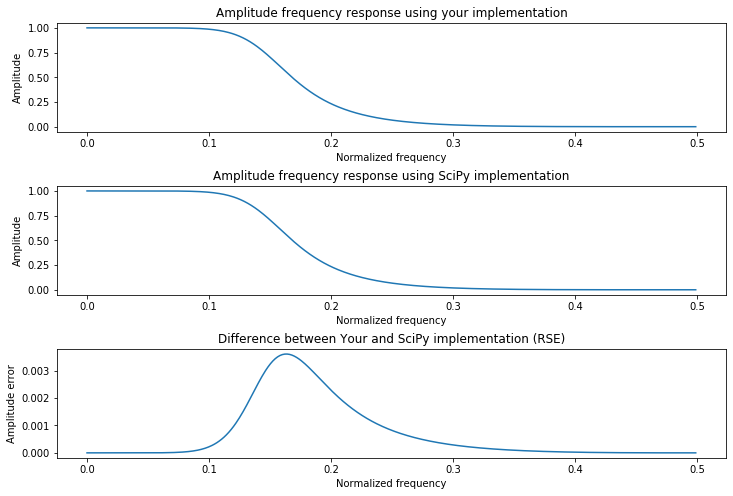

In [7]:
# IIR filter design
no, de = sig.iirfilter(4, 0.3, btype = 'lowpass')

# Calculating frequency response using your implementation
h = freqz(no, de, 512)
# Normalization
h = h / np.max(np.abs(h[0]))

# Calculating frequency response using SciPy implementation
w, h_ref = sig.freqz(no, de)
# Normalization
h_ref = h_ref / np.max(np.abs(h_ref[0]))

# Calculating error
RMSE = np.sum(np.abs(h) - np.abs(h_ref))

print('Your implementation succeeded!' if np.abs(RMSE) < 1 else 'Error is a little to big')

plt.figure(figsize = (12,8))

plt.subplot(3,1,1)
plt.plot(w/np.pi/2, np.abs(h))
plt.xlabel('Normalized frequency' )
plt.ylabel('Amplitude')
plt.title('Amplitude frequency response using your implementation')

plt.subplot(3,1,2)
plt.plot(w/np.pi/2, np.abs(h_ref))
plt.xlabel('Normalized frequency' )
plt.ylabel('Amplitude')
plt.title('Amplitude frequency response using SciPy implementation')

plt.subplot(3,1,3)
plt.plot(w/np.pi/2, np.abs(h_ref) - np.abs(h))
plt.xlabel('Normalized frequency')
plt.ylabel('Amplitude error')
plt.title('Difference between Your and SciPy implementation (RSE)')

plt.subplots_adjust(hspace=0.5)
plt.show()

## IIR impulse response

In [9]:
def draw_IIR(de, no, nsamples):
    """
    This function draws IIR impulse response, frequency amplitude response and poles and zeros on the z-plane.
    This function uses Your implementation of check_stability and freqz functions!!!
    
    Parameters
    ----------
    de: numpy array containing denominator of IIR transmitance.
    no: numpy array containing nominator of FIR transmitance.
    nsamples: int containing number of samples at which impulse response is calculated.    
    """
    print('\nDrawing begin, filter is stable. \n' if check_stability(de,no) else '\nDrawing begin, filter is unstable. \n')
    
    # Ploting zeros and poles
    zeros, poles, gain = sig.tf2zpk(no, de)
    t = np.linspace(0, 2*np.pi, 200)
    axes = np.max((np.max(np.abs(zeros)), np.max(np.abs(poles)), 1.5))
    
    plt.figure(figsize = (18,12))
    
    # Ploting unit circle zeros and poles
    plt.subplot(1,2,2)
    plt.plot(np.cos(t), np.sin(t), 'c--', linewidth=2)
    plt.plot(np.real(zeros), np.imag(zeros), 'ro', linewidth=4)
    plt.plot(np.real(poles), np.imag(poles), 'bx', linewidth=4)
    plt.xlabel('Imagine part')
    plt.ylabel('Real part')
    plt.legend(('Unit cicle', 'Zeros', 'Poles'))
    plt.xlim(-axes, axes)
    plt.ylim(-1.5*axes, 1.5*axes)
    
    # Ploting impulse response
    times = np.linspace(0,nsamples,100)
    IR = np.array(sig.impulse((no, de), T=times))
    
    plt.subplot(2,2,1)
    plt.plot(IR[0], IR[1])
    plt.title('Filter impulse response')
    plt.xlabel('Time in samples')
    plt.ylabel('Amplitude')
    
    # Ploting frequency response
    h = freqz(no,de,512)
    t = np.linspace(0,0.5,512)
    
    plt.subplot(2,2,3)
    plt.plot(t, np.abs(h))
    plt.title('Filter frequency amplitude response')
    plt.xlabel('Normalized frequency')
    plt.ylabel('Amplitude')
    plt.show()
    
    print('\nDrawing finished\n')
    return

Drawing characterists of stable and unstable IIR filters.


Drawing begin, filter is stable. 



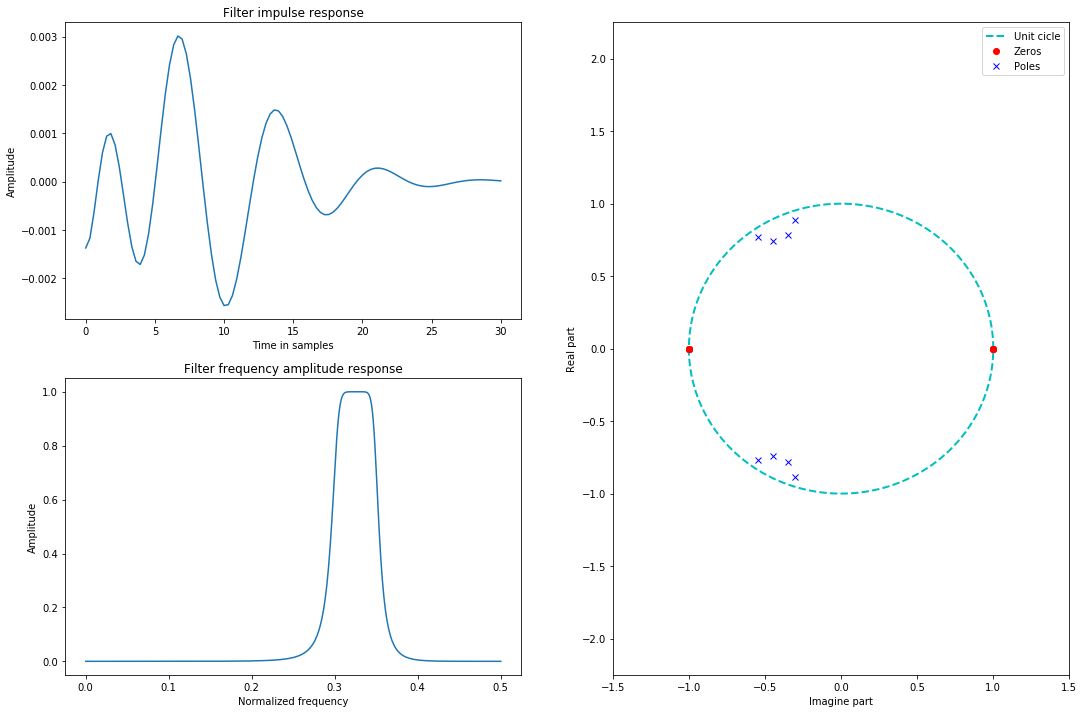


Drawing finished


Drawing begin, filter is unstable. 



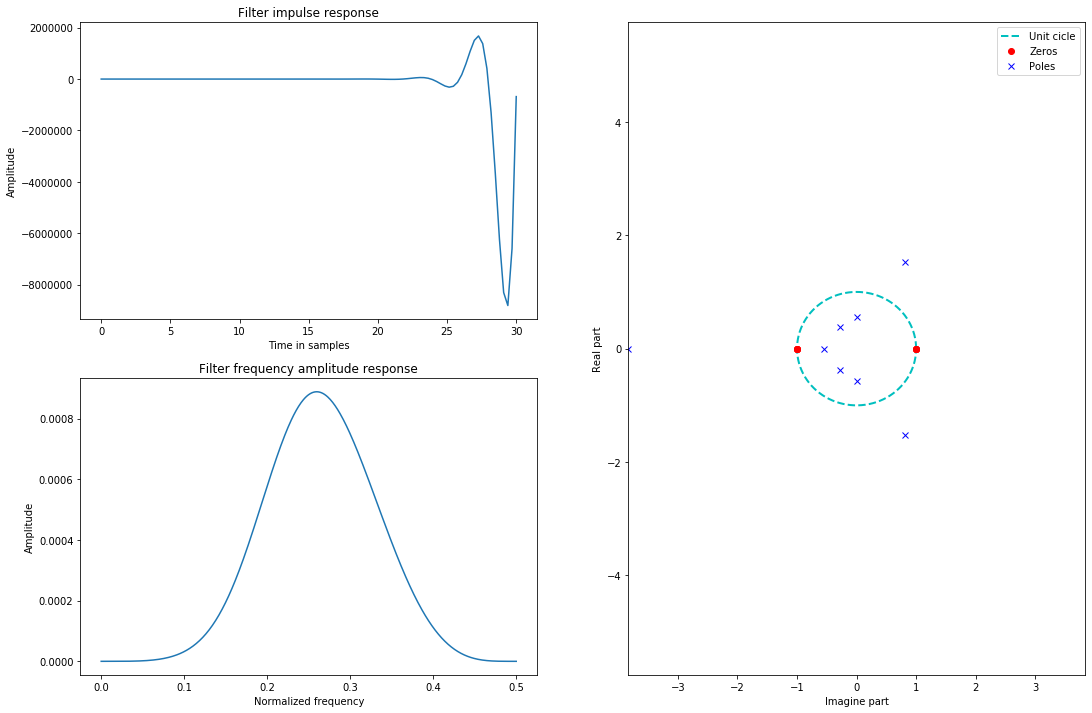


Drawing finished



In [61]:
nsamples = 30

# Stable filter design
no1, de1 = sig.iirfilter(4, [0.6, 0.7], btype = 'bandpass')

# Unstable filter design
no2 = no1.copy()
de2 = de1.copy()

# Changing one coefficient of filter to make it unstable
a1 = -0.001
de2[2] = a1

# Drawing stable filter characteristics
draw_IIR(de1, no1, nsamples)

# Drawing unstable filter characteristics
draw_IIR(de2, no2, nsamples)


### Question

- What is the difference between the impulse responses of these two filters?
- What is the differences in location of poles and zeros?

########## Your answers goes here ##########
Dla filtru pierwszego, wynikiem odpowiedzi na deltę Diraca jest sygnał wyjściowy zanikający do zera. Filtr więc jest stabilny (a nawet asymptotycznie stabliny, ponieważ dla s we(m) = 0, granica przy m dążącym do nieskończoności s wy(m) = 0)
Filtr drugi jest niestabliny, ponieważ wzbudza się w odpowiedzi na deltę Diraca.

Filtr jest stabliny, jeśli wszystkie bieguny transmitancji znajdują się w obszarze wykreślonym przez okrąg jednostkowy. To tłumaczy różnicę w odpowiedzi impulsowej filtrów.


## Practical IIR  design

### Exercise 

- Using [scipy.signal.iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) (or other) function design Butterworth, Chebyshev type I, Chebyshev type II and Eliptic 4th order lowpass filter. Its normalized cutoff frequency should be 0.3. 
- Draw frequency responses of all these filters on one plot. 
- Try to choose the parameters (without changing filter order) of individual filters so that the frequency responses are as similar as possible

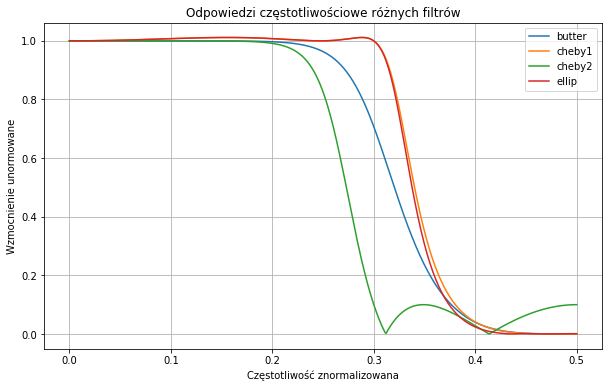

In [16]:
########## Your code goes here ##########
N = 4                            # rząd filtru
fc = 0.3                         # znormalizowana częstotliwość odcięcia
worN = 512                       # numery próbek gdzie liczymy odpowiedź częstotliwościową
fs = 1                           # częstotliwość próbkowania, powinna być taka sama, jak ta w funkcji freqz
f = np.linspace(0, fs/2, worN)   # wektor częstotliwości
fn = f/fs                        # wektor częstotliwości unormowanej


no_butter, de_butter = sig.iirfilter(N, fc, btype='lowpass', ftype='butter', fs=fs)
h_butter = freqz(no_butter, de_butter, worN)
h_butter = np.abs(h_butter / np.max(np.abs(h_butter[0])))

no_cheby1, de_cheby1 = sig.iirfilter(N, fc, rp=0.1, rs=10, btype='lowpass', ftype='cheby1', fs=fs)
h_cheby1 = freqz(no_cheby1, de_cheby1, worN)
h_cheby1 = np.abs(h_cheby1 / np.max(np.abs(h_cheby1[0])))


no_cheby2, de_cheby2 = sig.iirfilter(N, fc, rp=0.1, rs=20, btype='lowpass', ftype='cheby2', fs=fs)
h_cheby2 = freqz(no_cheby2, de_cheby2, worN)
h_cheby2 = np.abs(h_cheby2 / np.max(np.abs(h_cheby2[0])))

no_ellip, de_ellip = sig.iirfilter(N, fc, rp=0.1, rs=60, btype='lowpass', ftype='ellip', fs=fs)
h_ellip = freqz(no_ellip, de_ellip, worN)
h_ellip = np.abs(h_ellip / np.max(np.abs(h_ellip[0])))


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(fn, h_butter, label='butter')
ax.plot(fn, h_cheby1, label='cheby1')
ax.plot(fn, h_cheby2, label='cheby2')
ax.plot(fn, h_ellip, label='ellip')
ax.set_title("Odpowiedzi częstotliwościowe różnych filtrów")
ax.set_xlabel('Częstotliwość znormalizowana')
ax.set_ylabel('Wzmocnienie unormowane')
ax.grid()

plt.legend()
plt.show()

### Question

- Characterize each type of filter in one sentence (note differences, advantages, disadvantages, tradeoffs).


########## Your answer goes here ##########
Filtr Butterwortha - brak zafalowań w paśmie przepustowym i zaporowym, charakterystyka fazowa najbardziej zbliżona do liniowej,
ale szerokie (mało strome) pasmo przejściowe.

Filtr Czebyszewa typu 1 - zafalowania w paśmie przepustowym, brak zafalowań w paśmie zaporowym, charakterystyka fazowa bardziej nieliniowa niż w type Butterwortha, za to węższe pasmo przejściowe.

Flitr Czebyszewa typu 2 - zafalowania w paśmie zaporowym, brak zafalowań w paśmie przepustowym, charakterystyka fazowa bardziej nieliniowa niż w typie Butterwortha, za to węższe pasmo przejściowe

Filtr eliptyczny - zafalowania zarówno w paśmie przepustowym jak i zaporowym, najbardziej nieliniowa charakterystyka fazowa, ale za to najwęższe pasmo przejściowe

### Exercise
- For AT LEAST two choosen types of filters from previous exercise:
    - Design 2'nd, 6'th and 60'th order filter.
    - Check stability of those filters using your implementation of check_stability function.
    - Draw its frequency responses on one plot 
    - Draw its poles and zeros on the separate plots. 
    
You should end up with 8 plots total. You can use draw_IIR function or its part.


Teraz rysujemy charakterystyki dla filtru o rzędzie:  2
Filtr Butterwortha jest  stabilny
Flitr eliptyczny jest  stabilny


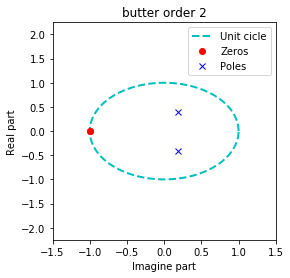

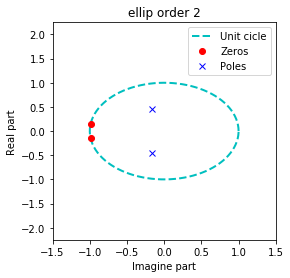

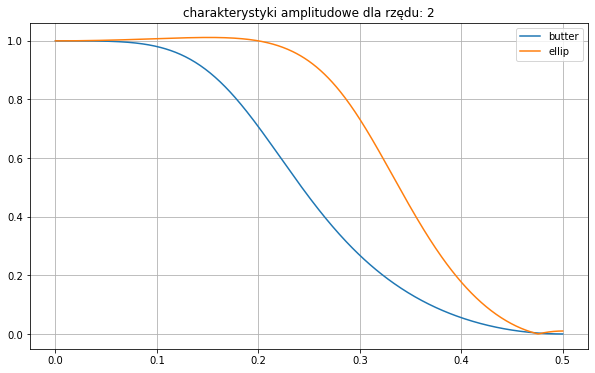

Teraz rysujemy charakterystyki dla filtru o rzędzie:  6
Filtr Butterwortha jest  stabilny
Flitr eliptyczny jest  stabilny


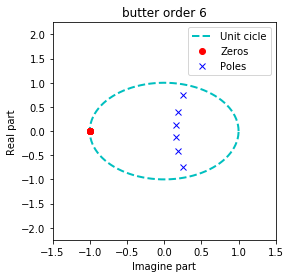

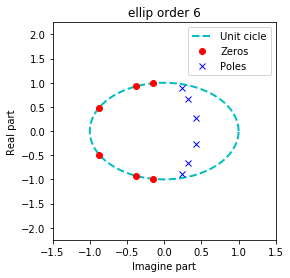

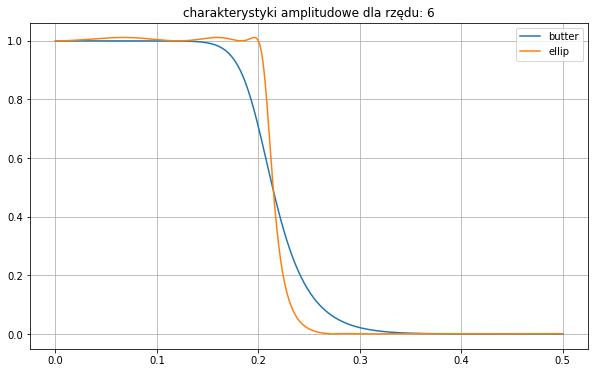

Teraz rysujemy charakterystyki dla filtru o rzędzie:  60
Filtr Butterwortha jest  stabilny
Flitr eliptyczny jest  niestabilny


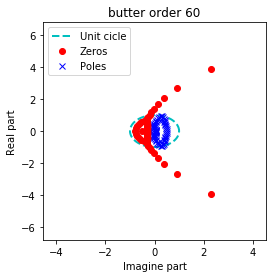

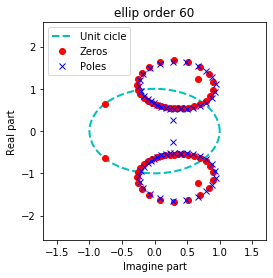

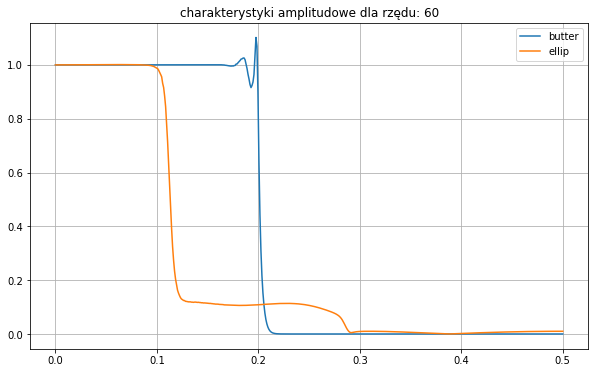

In [9]:
def draw_zeros_and_poles(no, de , type_of_filter, order):
    # 'type_of_filter' i 'order' to stringi (choć 'order' trzeba zrzutować na string),
    # podane do funkcji w celu adekwatnego 'podpisania' wykresu zer i biegunów
    
    # Ploting zeros and poles
    zeros, poles, gain = sig.tf2zpk(no, de)
    
    t = np.linspace(0, 2*np.pi, 200)
    axes = np.max((np.max(np.abs(zeros)), np.max(np.abs(poles)), 1.5))
    
    plt.figure(figsize = (4,4))
    
    # Ploting unit circle zeros and poles
    plt.subplot(1,1,1)
    plt.plot(np.cos(t), np.sin(t), 'c--', linewidth=2)
    plt.plot(np.real(zeros), np.imag(zeros), 'ro', linewidth=4)
    plt.plot(np.real(poles), np.imag(poles), 'bx', linewidth=4)
    plt.xlabel('Imagine part')
    plt.ylabel('Real part')
    plt.legend(('Unit cicle', 'Zeros', 'Poles'))
    plt.xlim(-axes, axes)
    plt.ylim(-1.5*axes, 1.5*axes)
    
    order = str(order)
    temp = np.char.add(type_of_filter, " order ")   # np.char.add() służy do łączenia stringów
    my_title = np.char.add(temp, order)
    plt.title(my_title)
    

########## Your code goes here ##########

fc = 0.2                        #  znormalizowana częstotliwość odcięcia
fs = 1                          # częstotliwość próbkowania
worN = 512                      # liczba współczynników gdzie będziemy liczyć charakterystykę amplitudową
f = np.linspace(0, fs/2, worN)  # wektor częstotliwości
fn = f/fs                       # częstotliwość znormalizowana
N = np.array([2, 6, 60])        # rzędy filtrów, jakie będziemy badać
ripple_passband = np.array([0.1, 0.1, 0.01])      #  parametry zafalowań w paśmie przepustowym oraz tłumienia w paśmie zaporowym
stopband_attenuation = np.array([40, 60, 40]) # odpowiednio dla 2, 6 i 60 rzędu filtru eliptycznego
                                            

for order, rip_pass, stop_att in zip(N, ripple_passband, stopband_attenuation):
    
    print('Teraz rysujemy charakterystyki dla filtru o rzędzie: ', order)
    
    # filtr Butterwortha
    no_butter, de_butter = sig.iirfilter(order, fc, btype='lowpass', ftype='butter', fs=fs)
    butter_stability = check_stability(de_butter, no_butter)
    print('Filtr Butterwortha jest ', 'stabilny' if butter_stability else 'niestabilny')
    draw_zeros_and_poles(no_butter, de_butter, 'butter', order)
    
    # filtr eliptyczny
    no_ellip, de_ellip = sig.iirfilter(order, fc, rp=rip_pass, rs=stop_att, btype='lowpass', ftype='ellip', fs=fs)
    ellip_stability = check_stability(de_ellip, no_ellip)
    print('Flitr eliptyczny jest ', 'stabilny' if ellip_stability else 'niestabilny')
    draw_zeros_and_poles(no_ellip, de_ellip, 'ellip', order)
    
   # obliczamy charakterystyki częstotliwościowe poszczególnych filtrów
    h_butter = freqz(no_butter, de_butter, worN)
    h_ellip = freqz(no_ellip, de_ellip, worN)
     
    # rysujemy charakterystyki amplitudowe
    fig, ax_amp = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    ax_amp.plot(fn, np.abs(h_butter / np.max(np.abs(h_butter[0]))), label='butter')
    ax_amp.plot(fn, np.abs(h_ellip / np.max(np.abs(h_ellip[0]))), label='ellip')
    ax_amp.legend()
    ax_amp.grid()
    
    order = str(order)
    temp = "charakterystyki amplitudowe dla rzędu: "
    my_title = np.char.add(temp, order)
    ax_amp.set_title(my_title)
    
    plt.subplots_adjust(hspace=0.5)
    plt.show() 

### Question

- What happens if we use to low order filtration
- What happens if we use to high order filtration

########## Your answer goes here ##########

In [ ]:
Gdy użyjemy zbyt małej liczby współczynników filtru, to ciężko jest uzyskać wystarczająco wąskie pasmo przejściowe (np. dla
filtru pierwszego rzędu można uzyskać maksymalne tłumienie 20 db na dekadę) - zbyt mała selektywność filtru

Gdy użyjemy zbyt dużej liczby współczynników filtru, to filtr może stać się niestabilny na skutek skończonej dokładności
obliczania jego współczynników (to że filtr 60 rzędu Butterwortha wyszedł mi stabilny, jest raczej szczęśliwym zrządzeniem 
losu, niż regułą).